<a href="https://colab.research.google.com/github/kayalash8/mnist-digit-recognition/blob/main/MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Neural Networks with MNIST

ACM AI Applied Track (Winter 2024)

# First, we need to import a few libraries to make things work


1) Numpy

2) Torch

3) Torchvision

4) Matplotlib

5) Sklearn

In [32]:
import numpy as np
import torch
import torchvision
import torch.nn.functional as F
from torch import nn, optim, utils
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import random

from sklearn import metrics
from matplotlib import pyplot as plt

# Creating Classes

There are two main classes we need to create: our dataset class and our actual model

# The Dataset Class

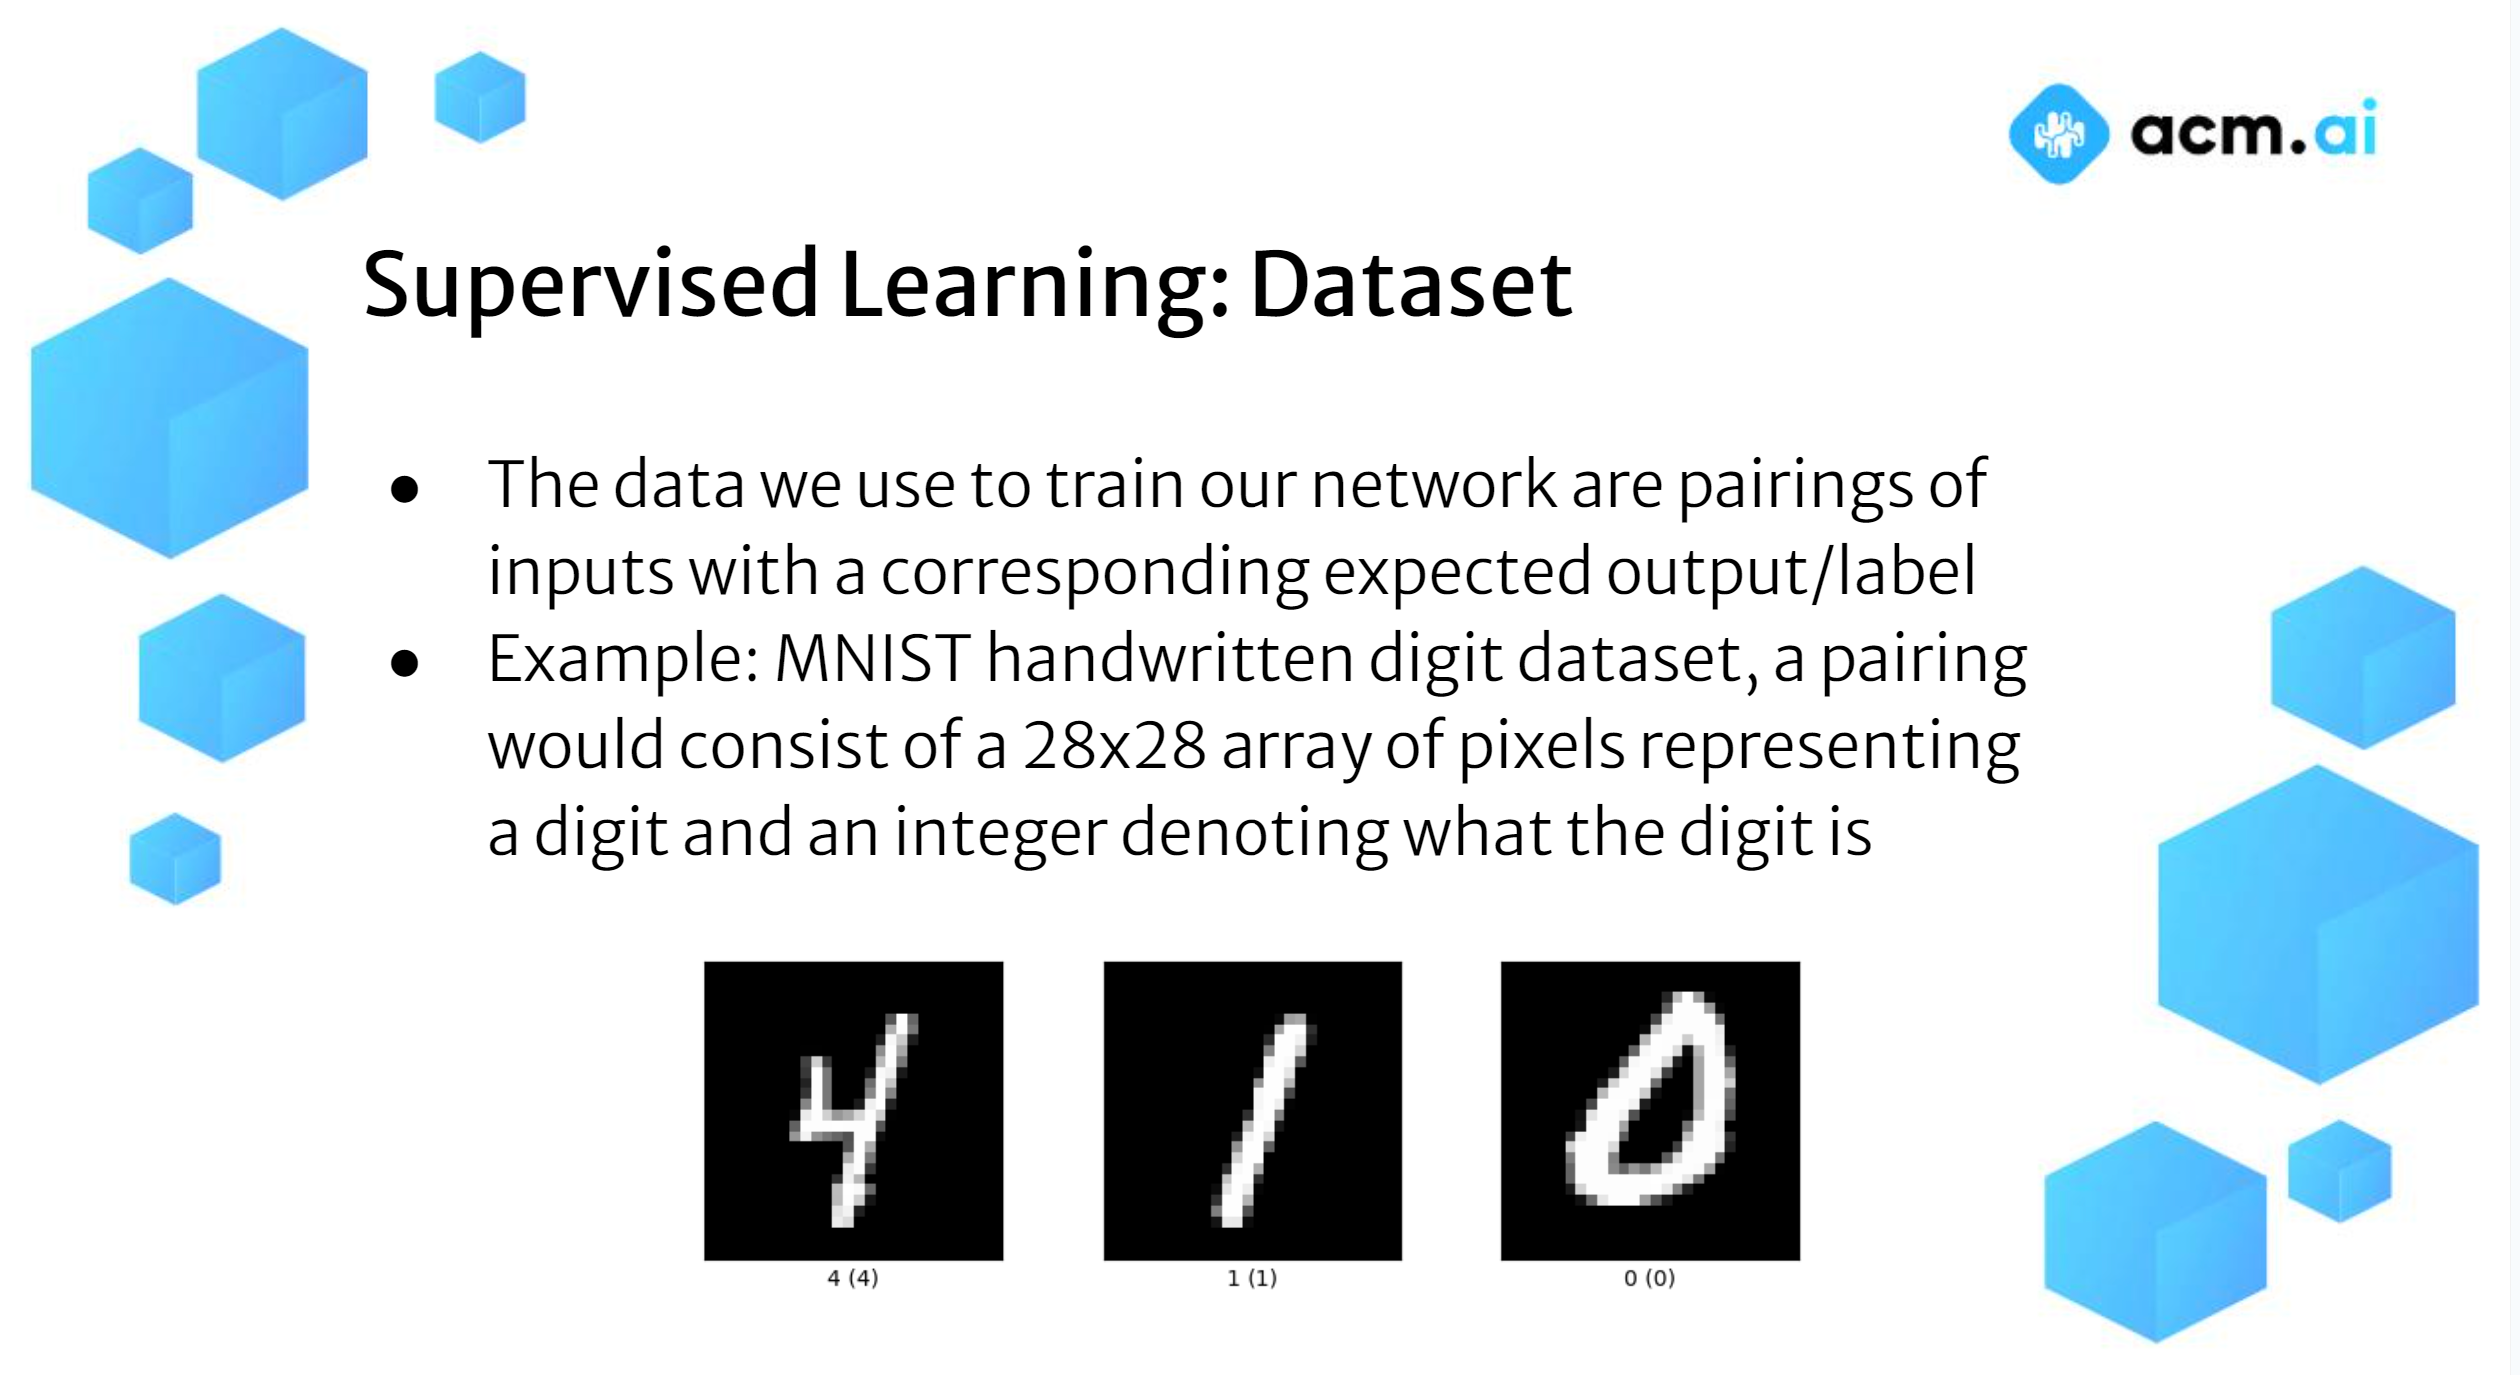

In [33]:
#What are batches? Why do we use them?
#What are the 3 functions we must define here?

class CustomDataset(torch.utils.data.Dataset):
  def __init__(self, images, labels):
    self.x = images
    self.y =  labels
  def __getitem__(self, i):
    return (self.x[i], self.y[i])

  def __len__(self):
    leng = len(self.x)
    if leng == len(self.y):
      return leng
    else:
      return "Error"

  # About the Model Class

This is where we create the actual neural network! We'll start simple; for now, we'll just create a fully-connected network; convolutional layers and more sophisticated architectures will be reserved for higher-level notebooks.

To create a network, you need to create a class that inherits from nn.Module.

In this class, there are two main types of functions you will focus on
- 1. The constructor (this is where you will create the connections between layers)

          nameOfLayer = nn.Linear(numNeuronsInInputLayer, numNeuronsInOutputLayer)

- 2. The forward function (this is where you actually "wire" the layers together with activation functions)

          x = activationFunction (name_of_layer(x))
          ...
          return x

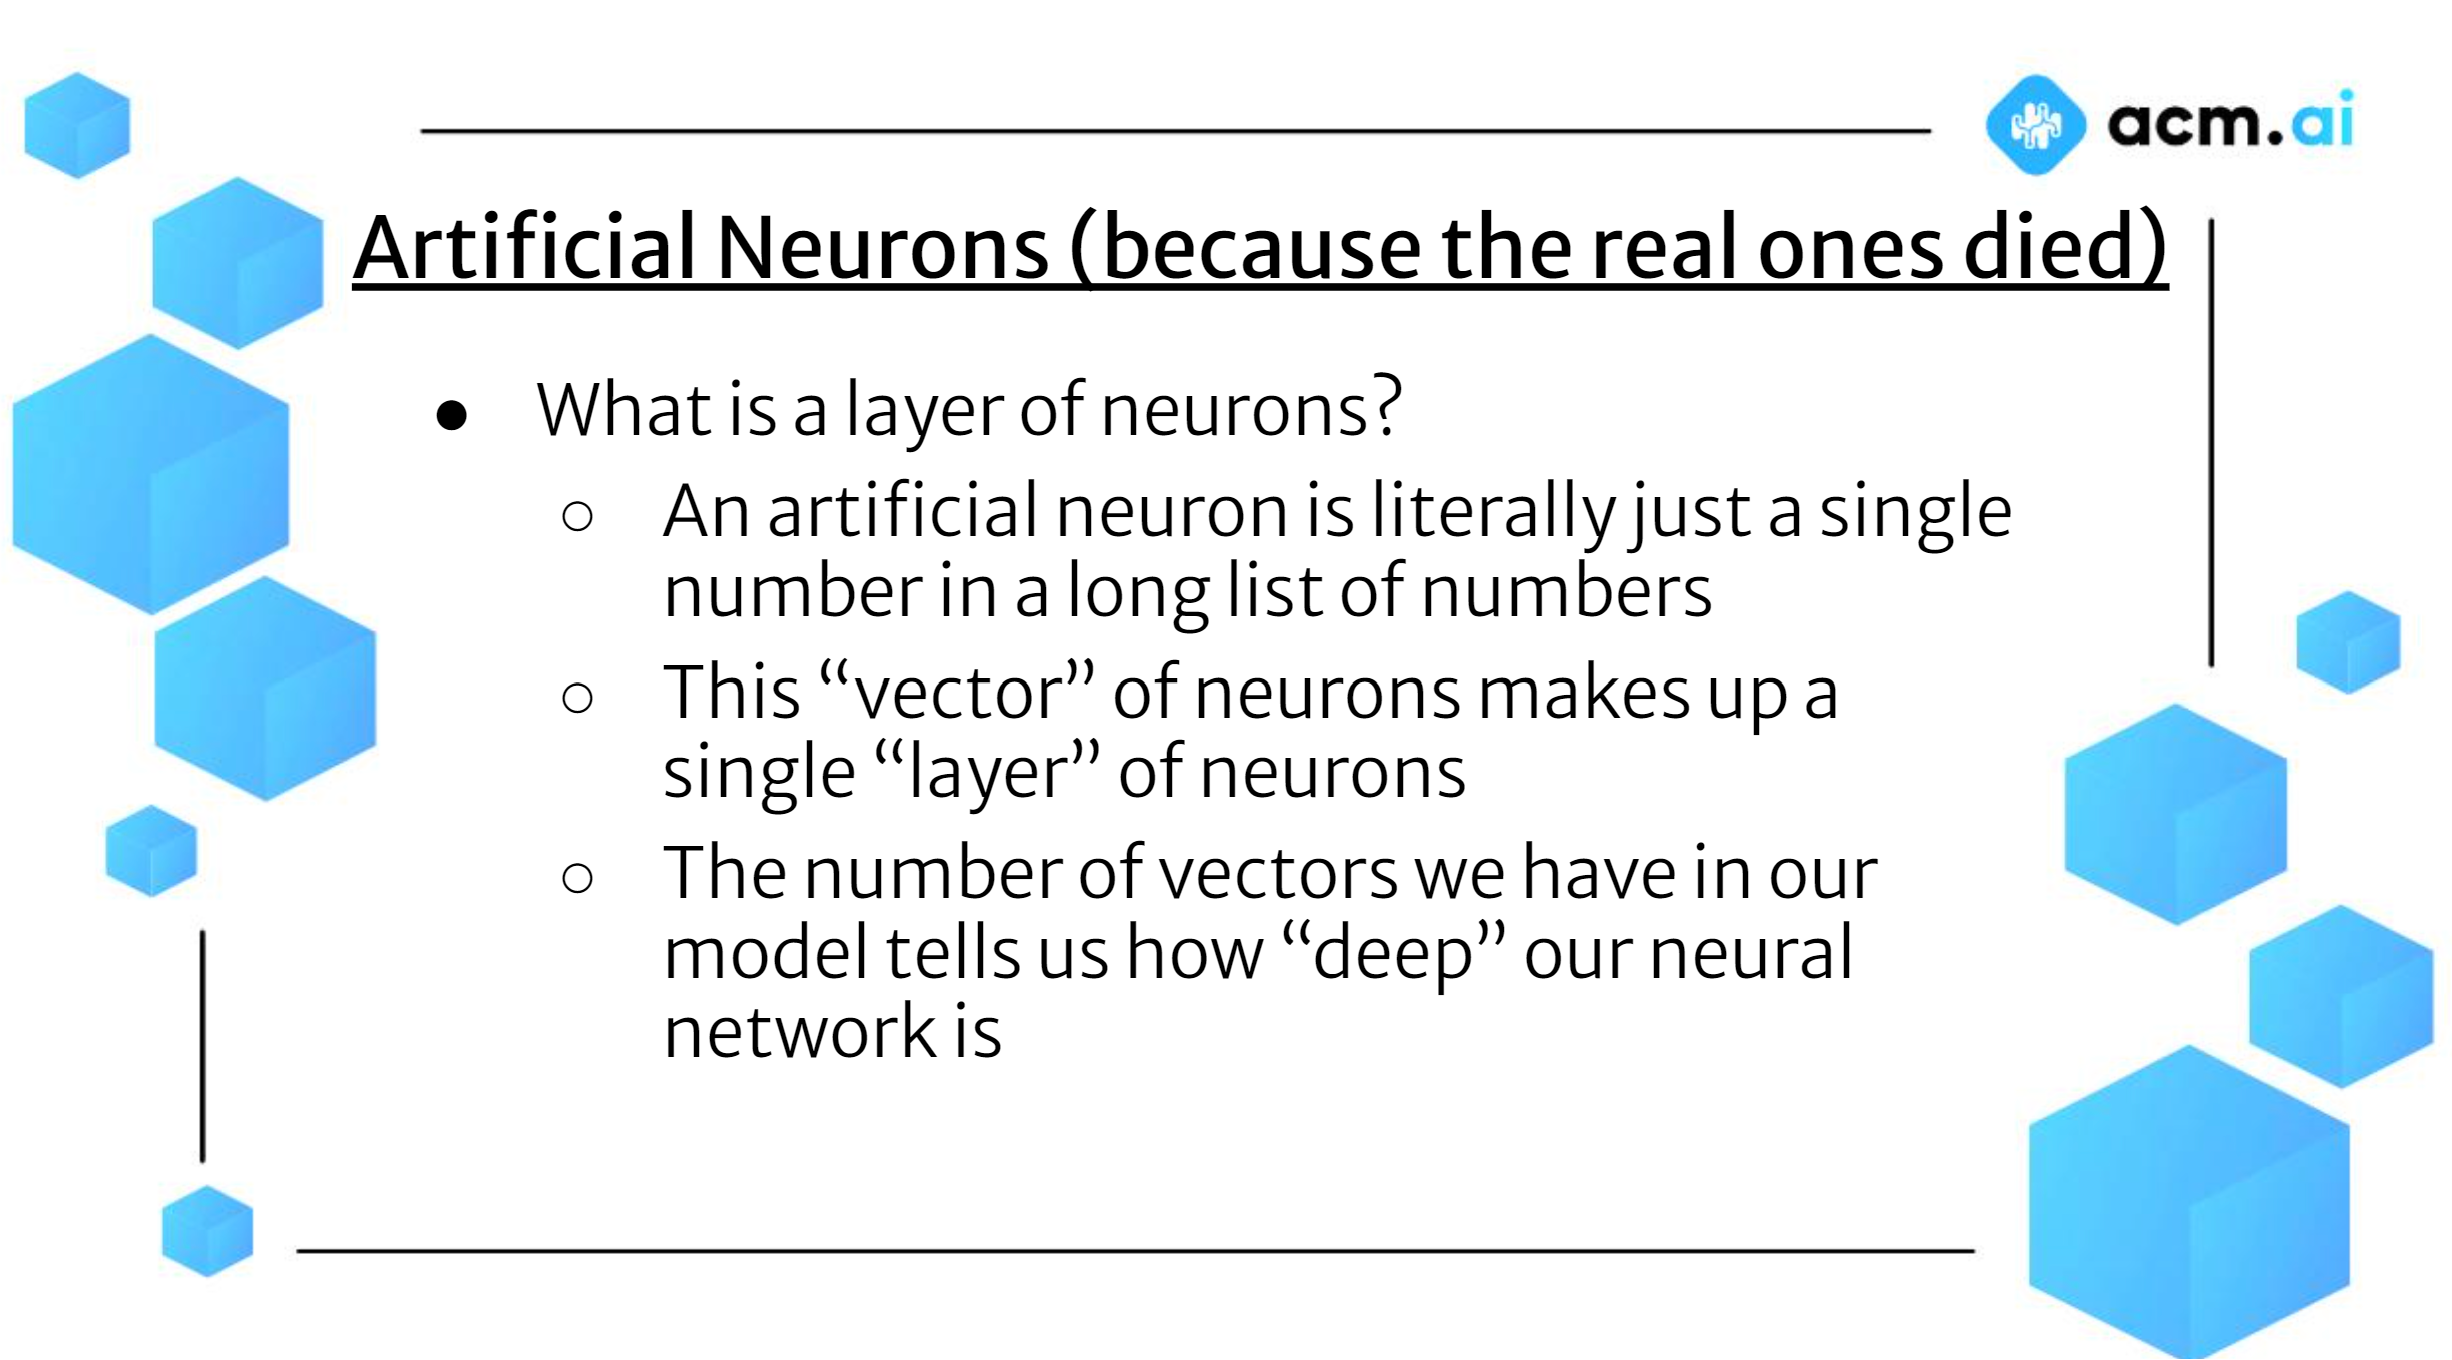

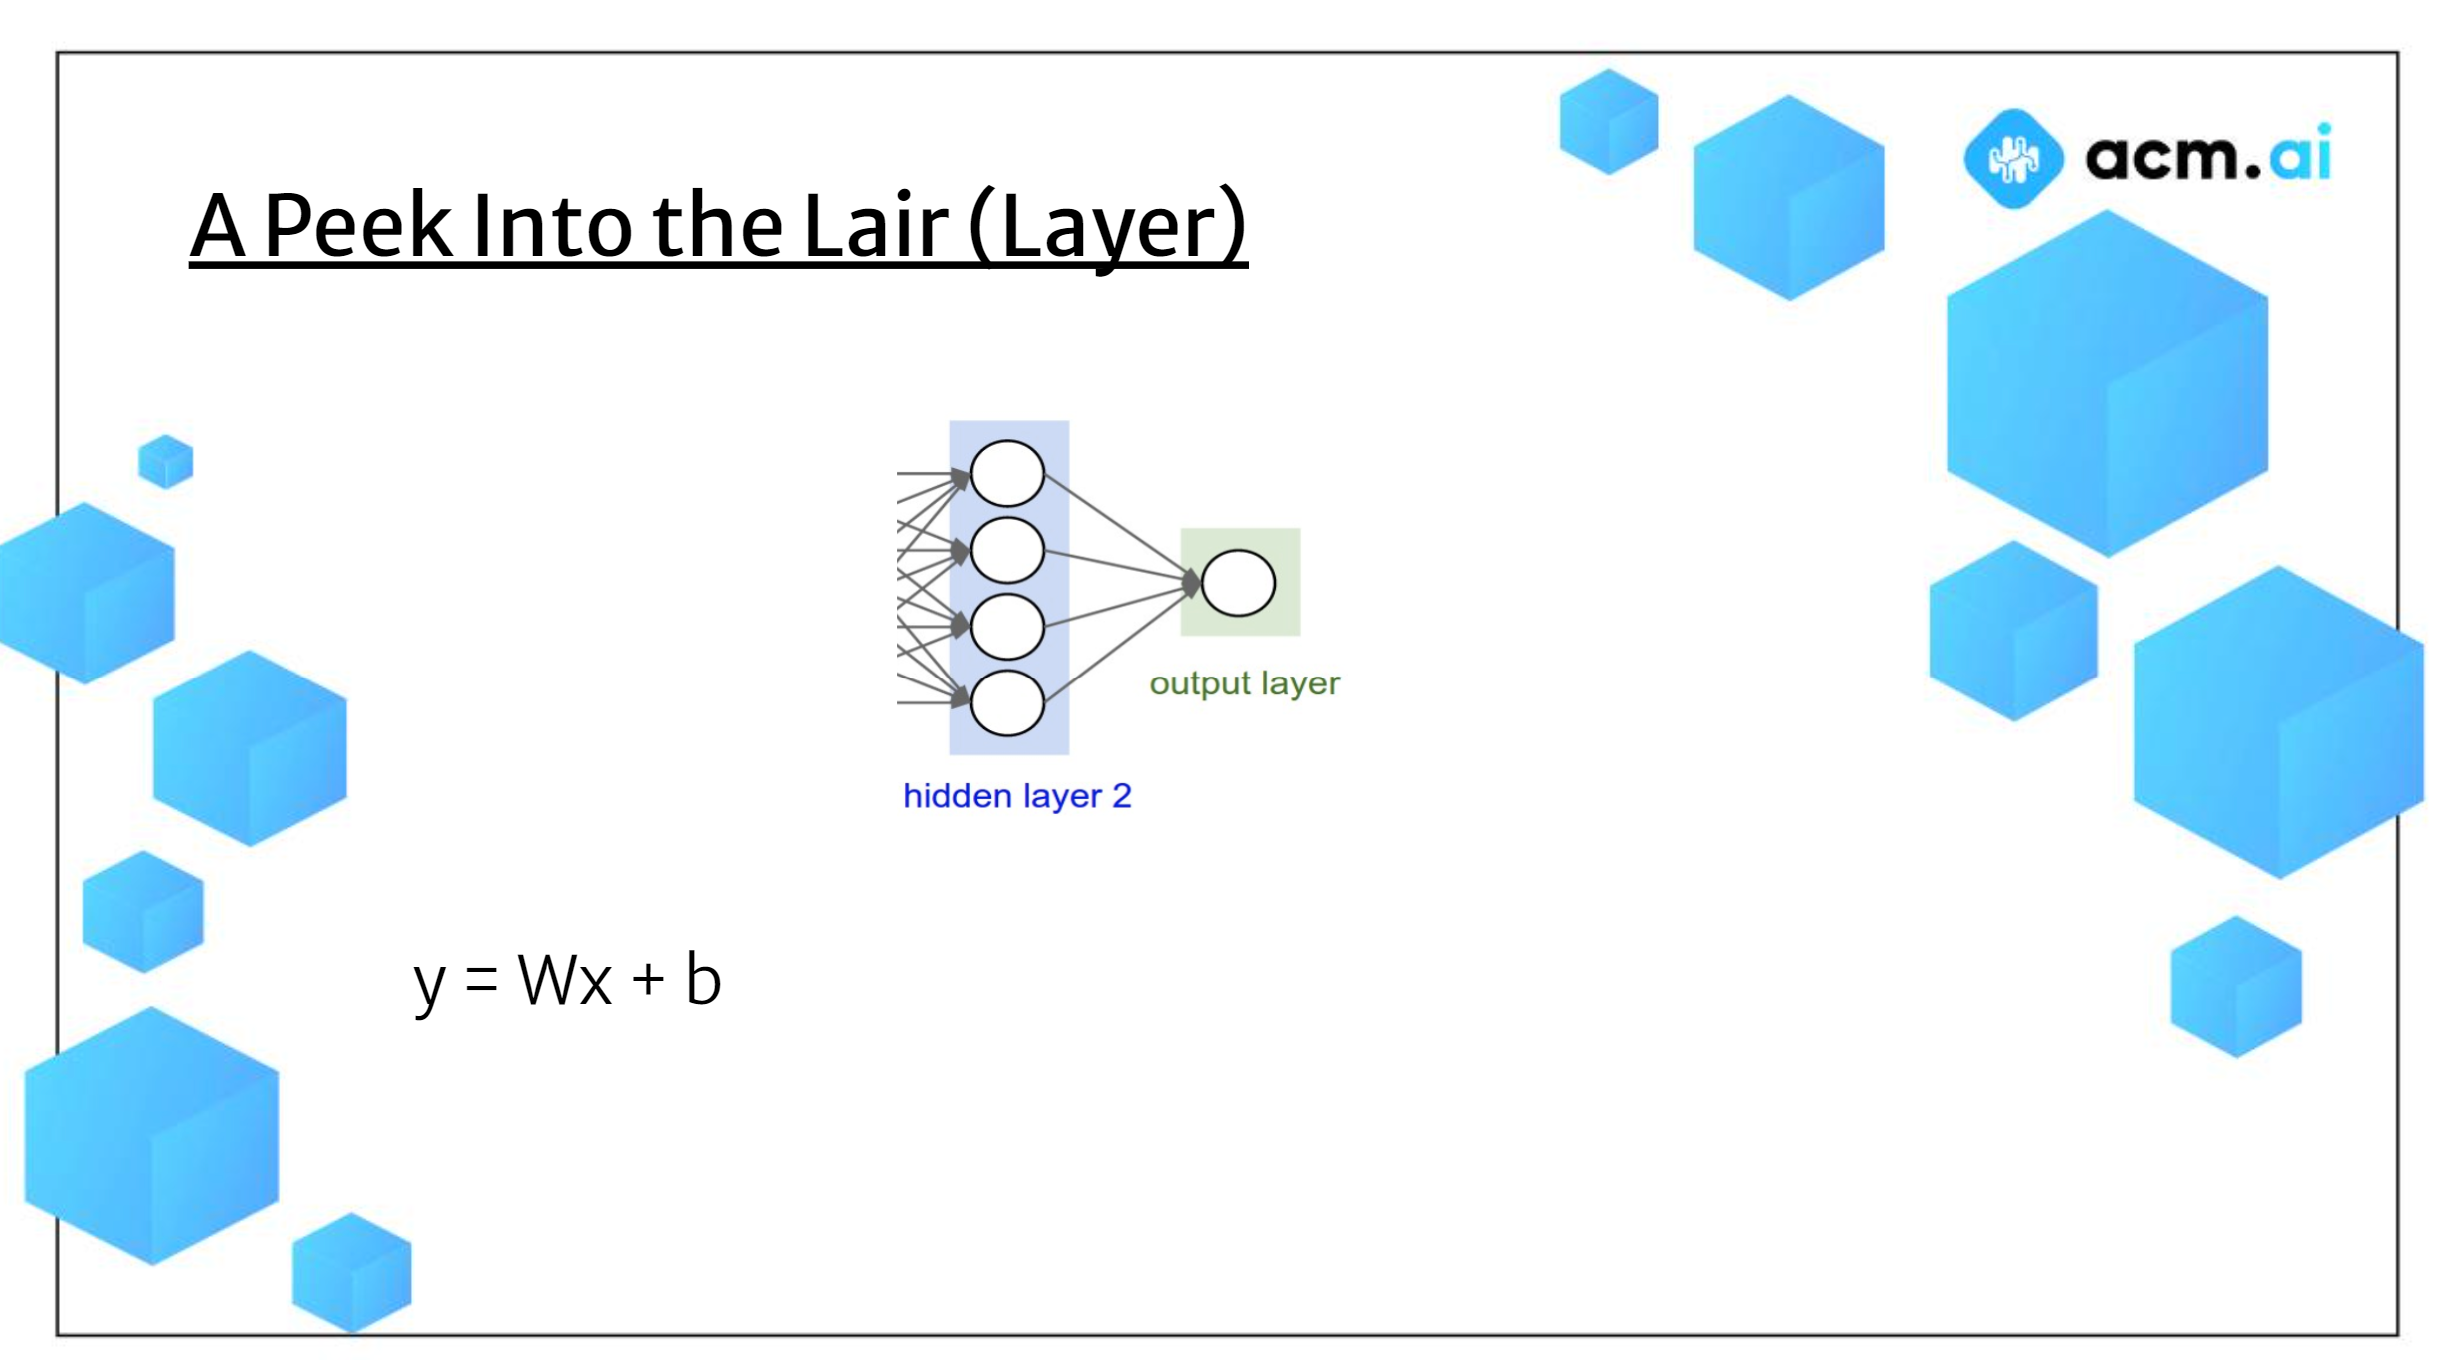


*   y is the output
*   w is weight the vector that's coming in
- sigma is an activation function

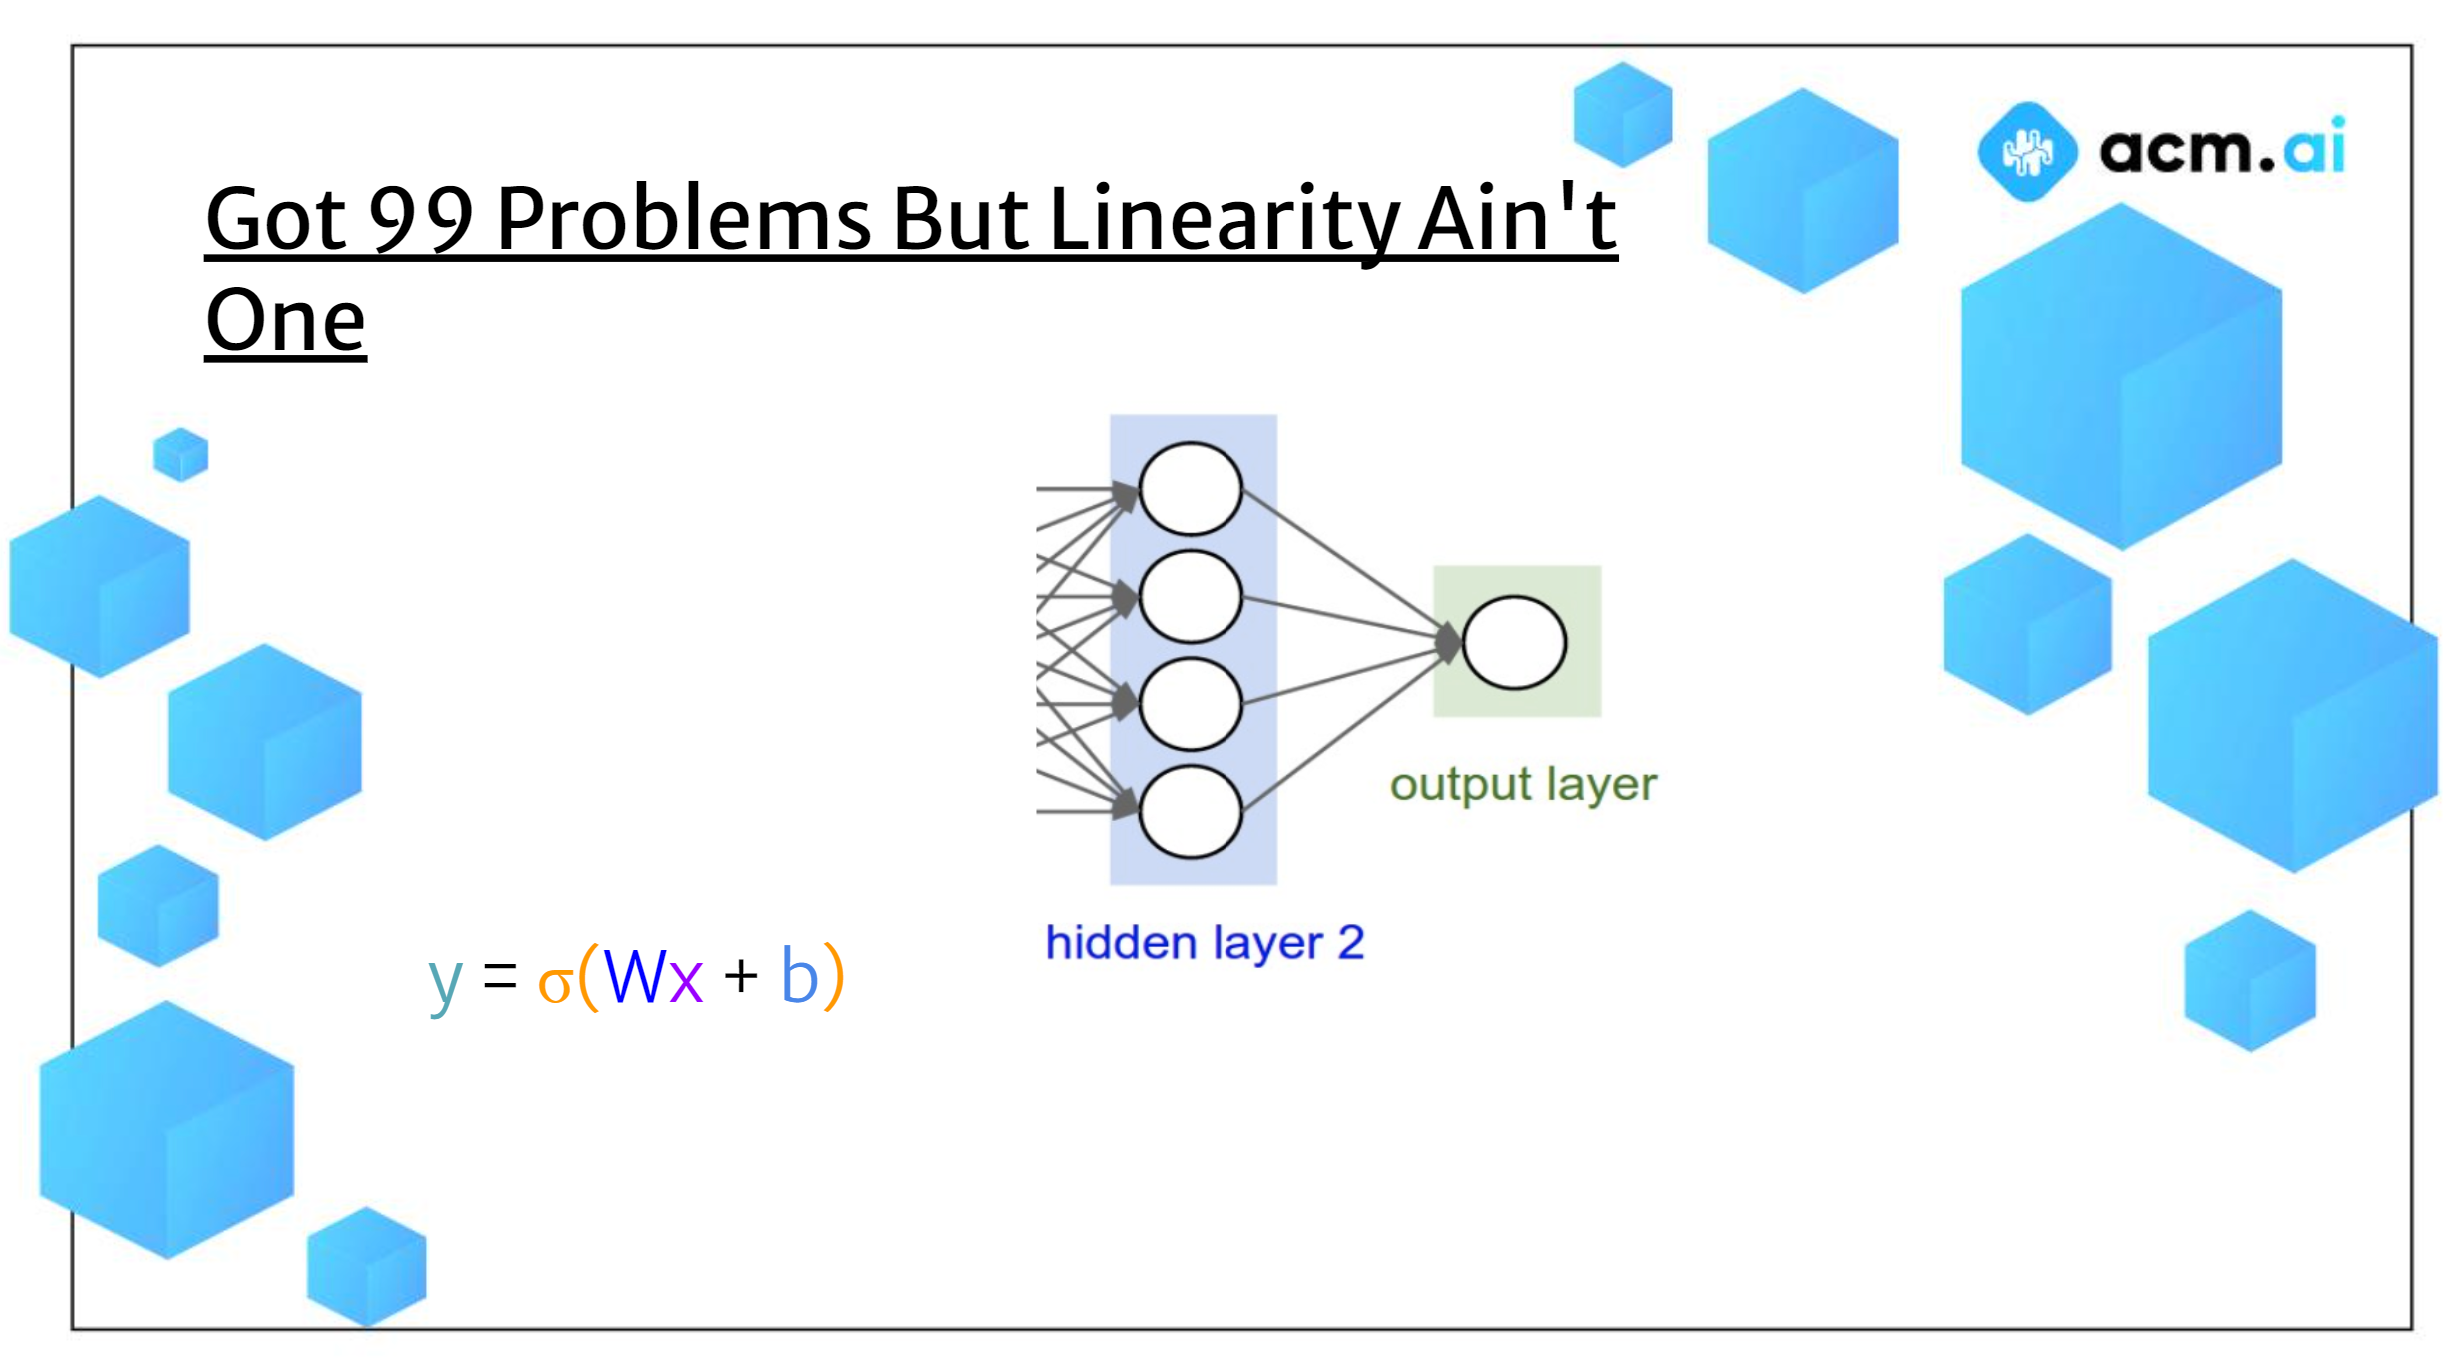

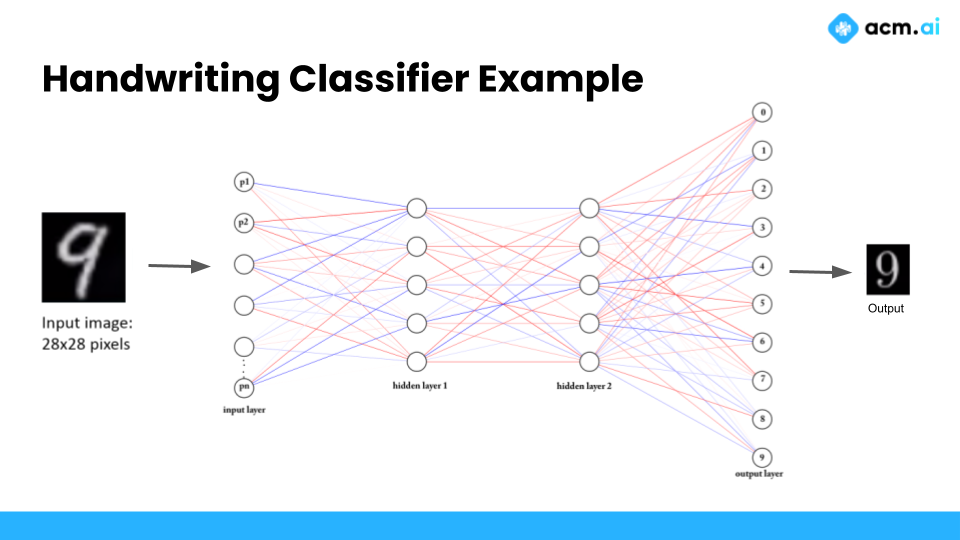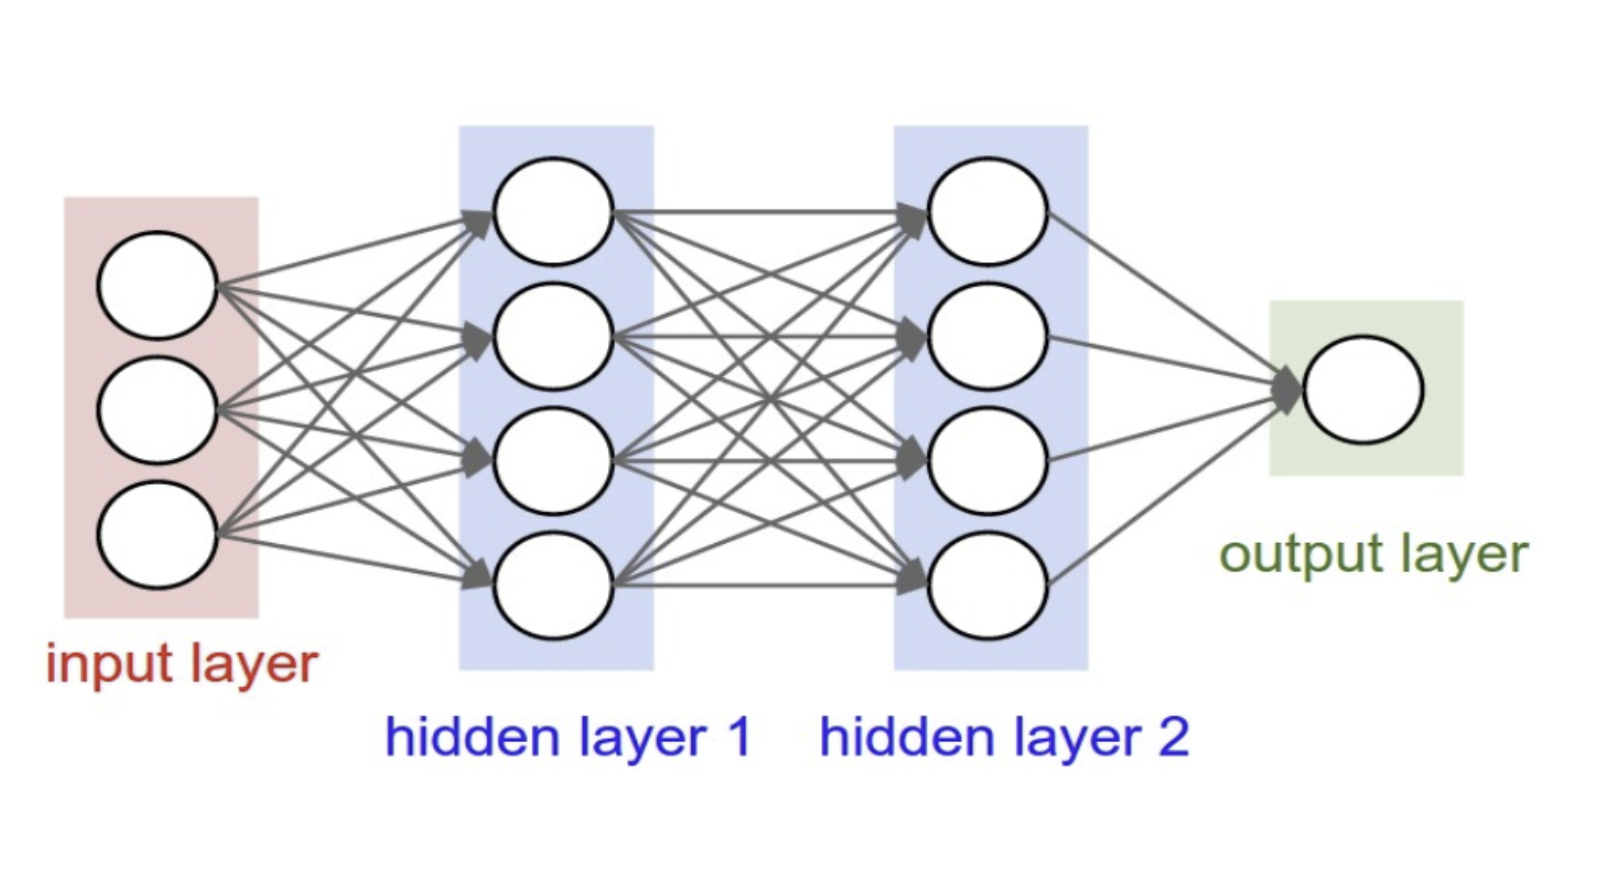

In [34]:
class CustomModel(nn.Module):
  def __init__(self): #one input layer, one hidden layer, one output layer
    super(CustomModel, self).__init__()
    self.layer1 = nn.Linear(784, 256) #28 x 28 every pixel, techincally any number between 10 (ouput layer) and 784
    self.layer2 = nn.Linear(256, 128) #previous number, next layer
    self.layer3 = nn.Linear(128, 10) #images from 0-9
    #strictly decreasing

  def forward(self, x):
    x = F.relu(self.layer1(x)) #We have used relu as our activation function for this layer
    # does this neuron matter or not 1 or 0
    x = F.relu(self.layer2(x))
    x = self.layer3(x)
    return x

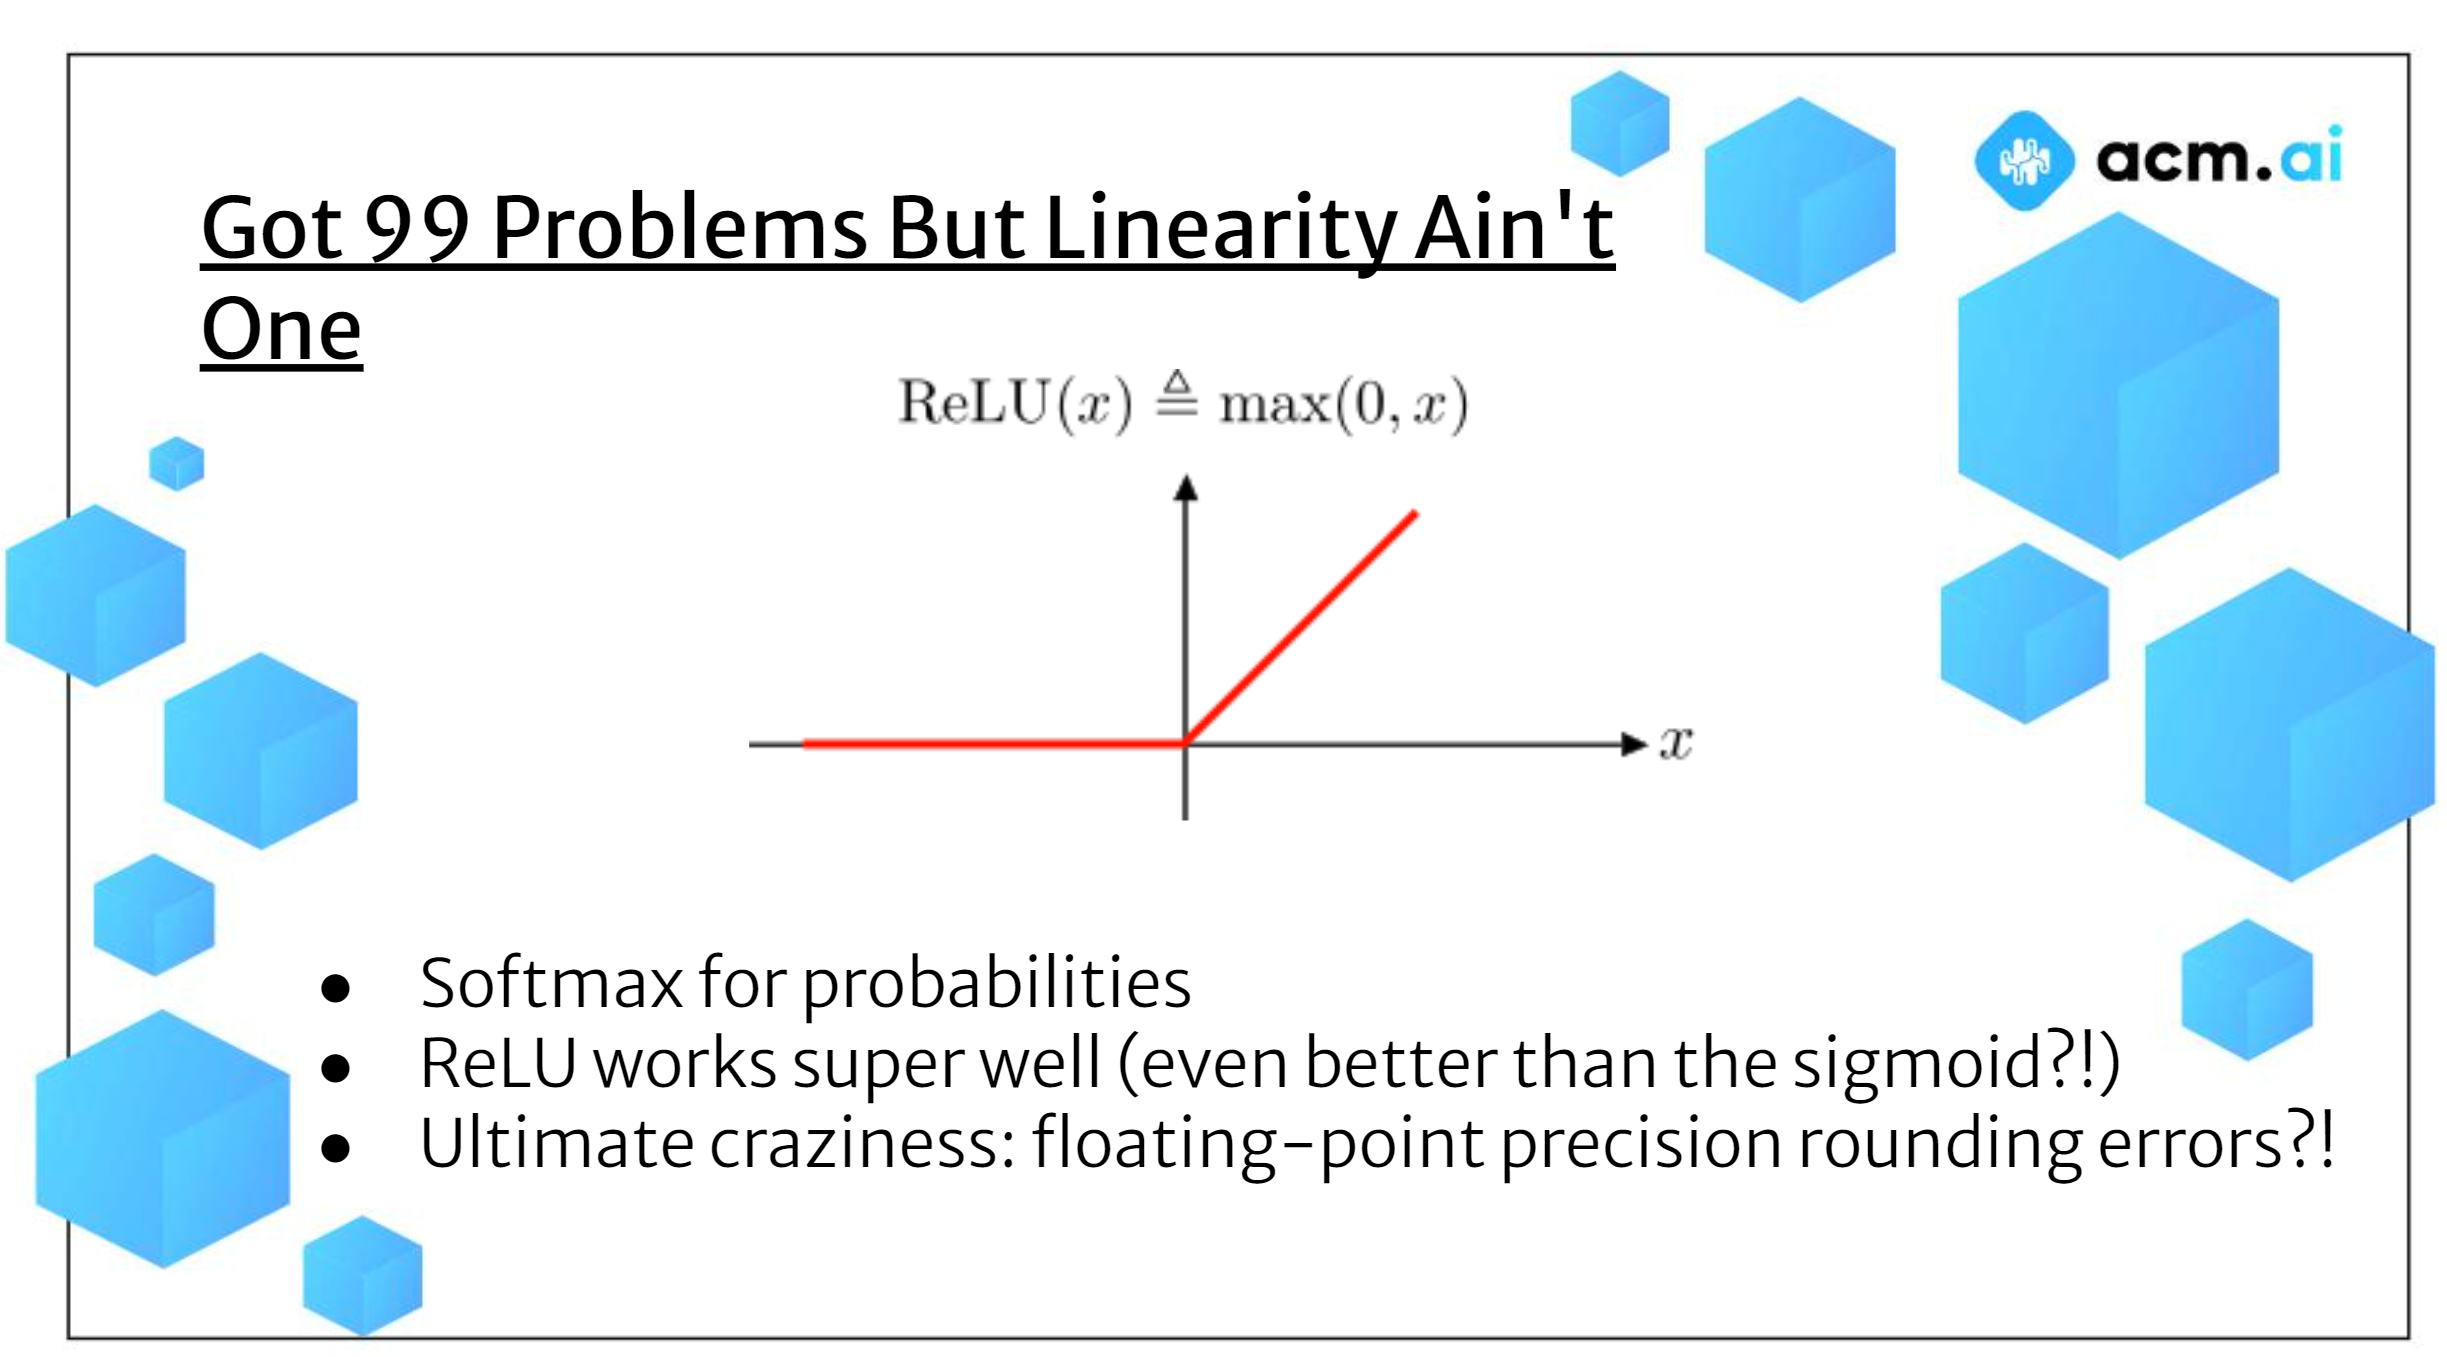

# The Training Loop

For our training loop, we need 4 things
- 1. A model to train
- 2. Data to learn from
- 3. A loss function to figure out how incompetent the model is and to figure out the gradient of our model
- 4. An optimizer to implement the backpropagation that actually makes the model better

      optimizer is the one doing the gradient descent
      backpropagation changes the variables to go backwards to make it better
      going backward to change to adjust the weight and the bias

Additional things to think about
- 1. Batch size

Our model calculates gradients by passing in a sample through the model, figuring out how badly it's done with the loss function, and then taking the derivative of the loss function with respect to each weight and bias in the model.

We could pass in more than one sample, and then update the weights and biases by the average gradient we get for each parameter.

The number of samples we pass in at a time is the batch size.

- 2. Epochs

When we go through every single piece of data in our training dataset, that completes one epoch (one epoch will typically have quite a few batches in it, where each batch consists of multiple pieces of data). We can train our model for multiple epochs so that it learns our training data (we want to be careful though; if it learns our training data too well, it won't be able to generalize to data it's never seen before).

Steps
- 1. Fix the inputs so that they're appropriate for the model
- 2. Get the predictions of your model.
- 3. Measure the how well your model predicts what it's supposed to with the loss function.
- 4. Do the backpropagation.

We just repeat these steps over and over again the training loop.

In [35]:
def trainingLoop(modeltoTrain, trainDataLoader, lossFunc, optimize, EPOCHS):
  modeltoTrain.train() #puts our model in training mode; very important
  for current_epoch in range(EPOCHS):
      for batch_inputs, actualClasses in iter(trainDataLoader):
          #Our batches are nx28x28 tensors, but our model expects a nx784 tensor. Where does nx28x28 come from, and what should we do to fix this problem?
          batch_inputs = torch.reshape(batch_inputs, [16, 784])#Alter the inputs to match the expected input to the model
          predictions = modeltoTrain(batch_inputs)#Pass the inputs into the model

          #the loss function has two inputs: the predictions made by the model and the actual classes it was supposed to predict
          #Enter those parameters into the loss function
          currentLoss = lossFunc(predictions, actualClasses)
          #do the backpropagation
          currentLoss.backward()
          #ACTUALLY adjust our model parameters to make our model slightly better
          optimize.step()
          #we need to reset our optimizer every time we call it because we recalculate our gradients on every iteration
          optimize.zero_grad()


      print("Epoch {} over; loss at the end of the epoch: {}".format(current_epoch+1, currentLoss.item()))

**Let's also create a function to evaluate how well our model has done its task.**

The process is almost exactly the same, with just a few differences:

- 1. We put our model in eval mode by saying modelToTrain.eval()
- 2. We don't do backpropagation

We'll be tracking information that can be used to find accuracy here. We can do this in the training loop as well, although in this example we haven't to make the training loop look less scary.

In [36]:
def evaluateModel(modelToEval, testDataLoader):
  modelToEval.eval() #puts our model in eval mode (very important)
  allPreds = torch.Tensor([])
  allAnswers = torch.Tensor([])

  for batch_inputs, actualClasses in iter(testDataLoader):
    batch_inputs = batch_inputs.view(batch_inputs.shape[0], -1)
    predicted_outputs = modelToEval(batch_inputs)

    predicted_classes = torch.argmax(predicted_outputs, dim=1)
    allPreds = torch.cat([allPreds, predicted_classes]) #Add the list of predicted outputs to our running total
    allAnswers = torch.cat([allAnswers, actualClasses]) #Add the list of true classes to our running total
  return allPreds, allAnswers #We will use the predicted outputs and the real classes to judge our model

# Phew! Now we can get to actually training our models!

# Setting up our data

- 1. Get the training data and testing data (this has already been done for you; the implementation of this will vary depending on where you get your data from).

If we had a more complicated workflow, we would actually make use of our CustomDataset class here, but we don't need to; that was more for your practice (because you will need to know how to make one if you work with ML models in the future).



- 2. Define your data loaders for your training and testing data

The dataloader essentially divides up your data into random batches. If you iterate through the dataloader, you iterate through the batches until you complete an epoch. If you keep iterating, you loop back around.

The dataloader is a class defined within torch.utils.data.DataLoader.
To instantiate it, you need to pass in your actual dataset, a batch size, and whether you want to shuffle your dataset (which you always should).

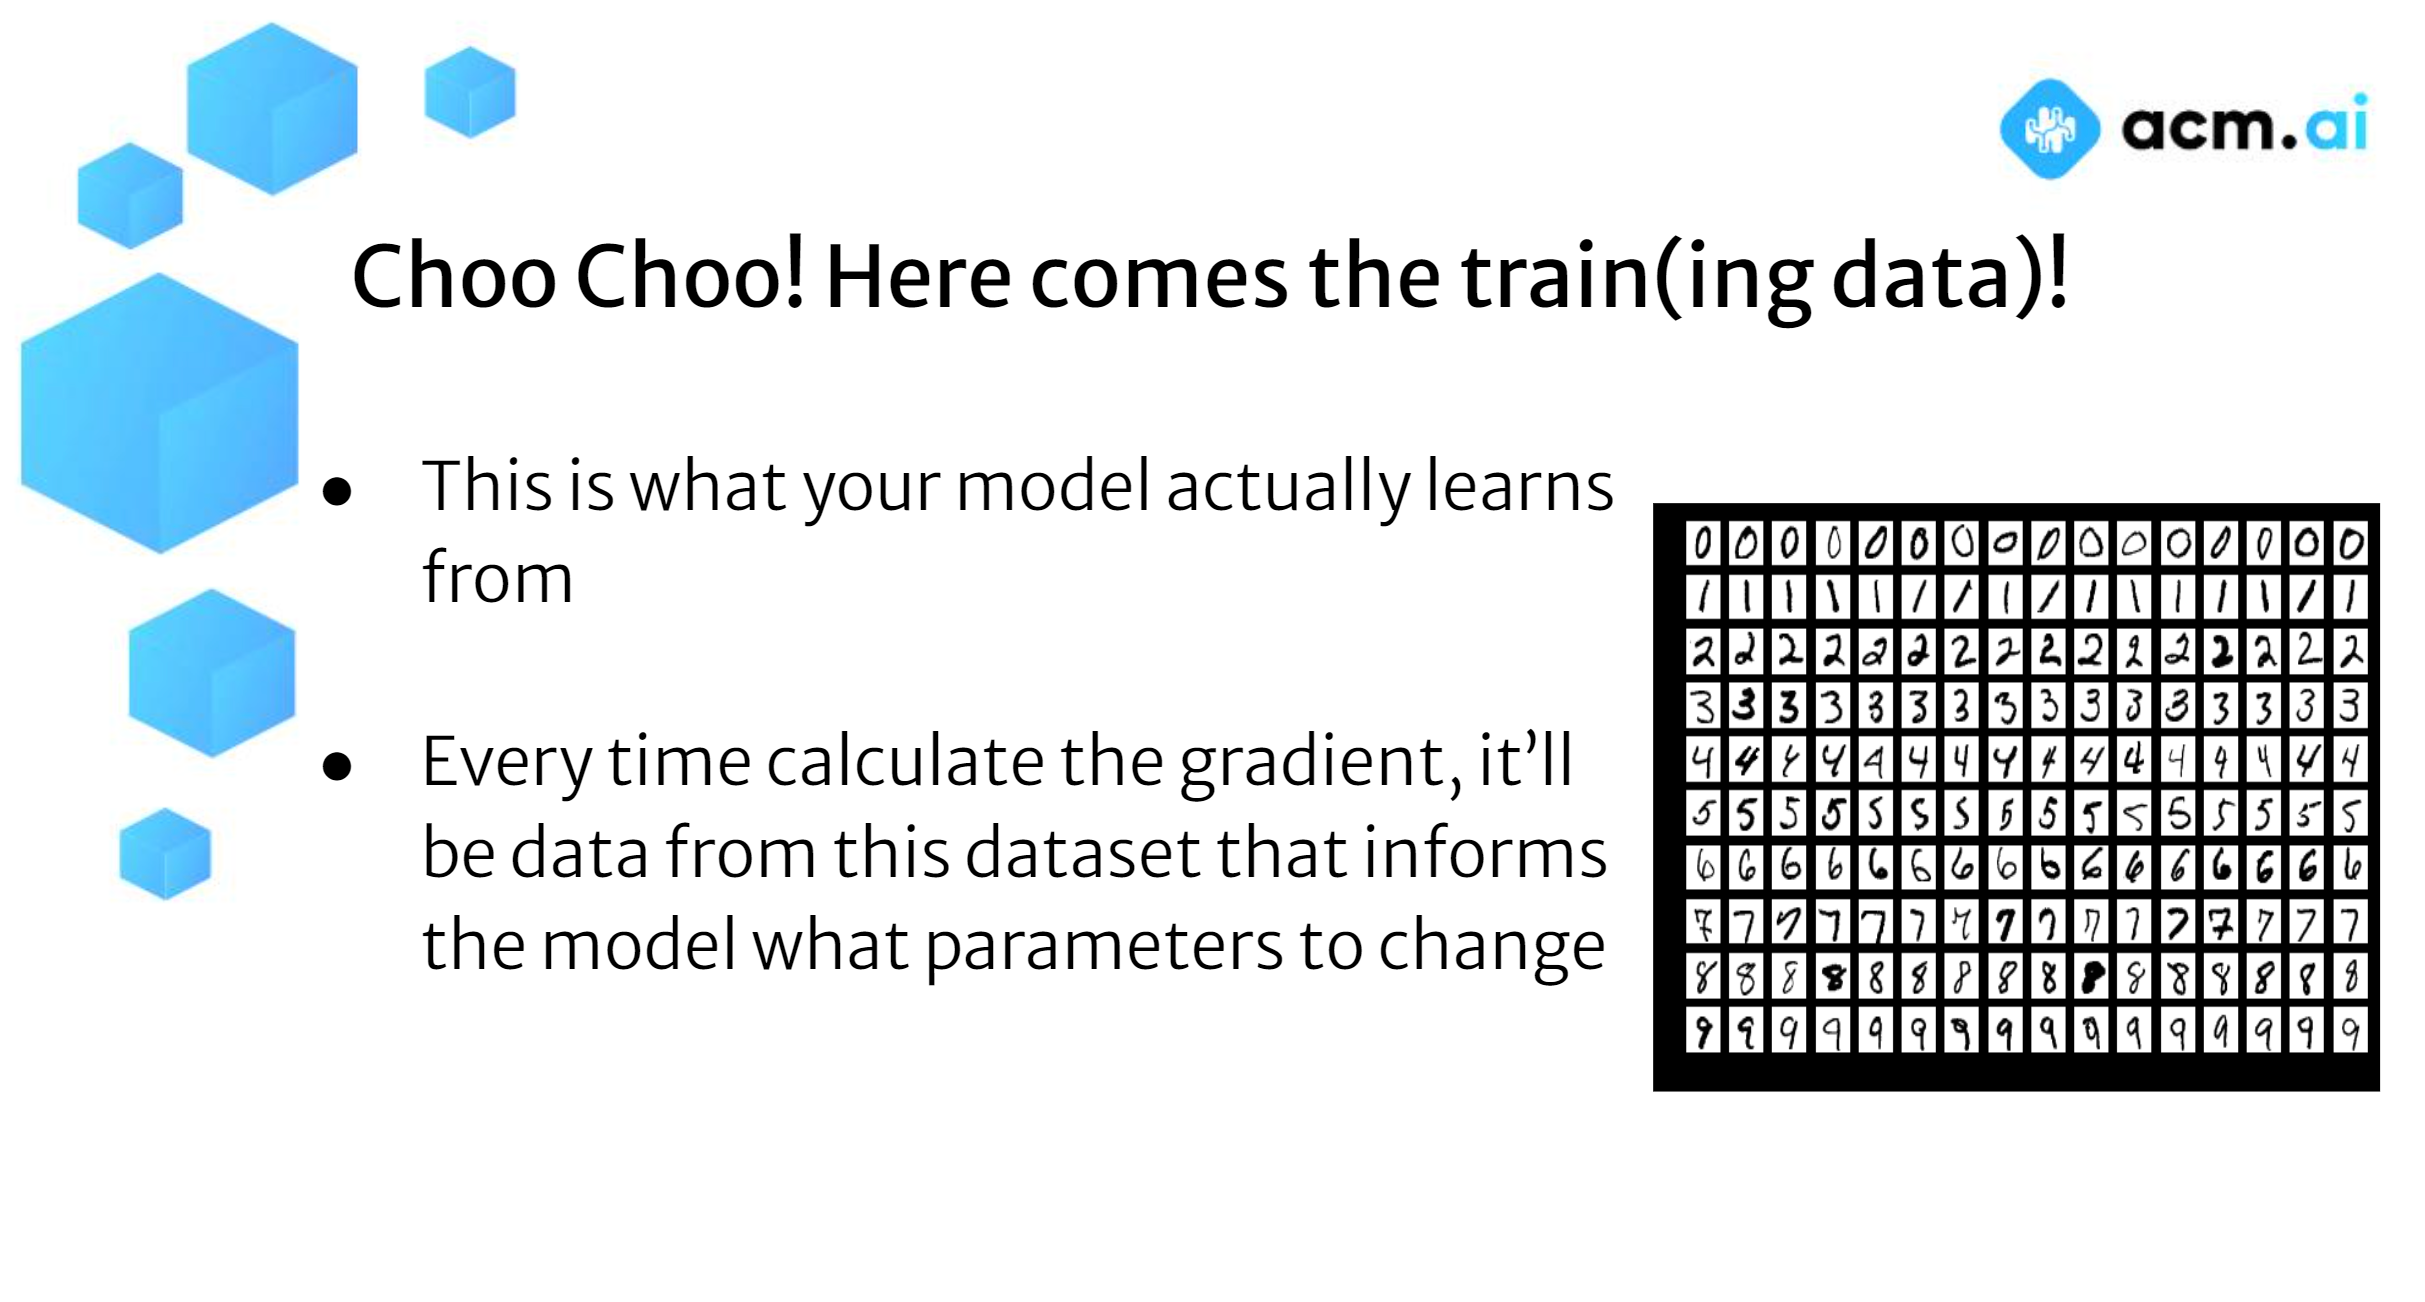

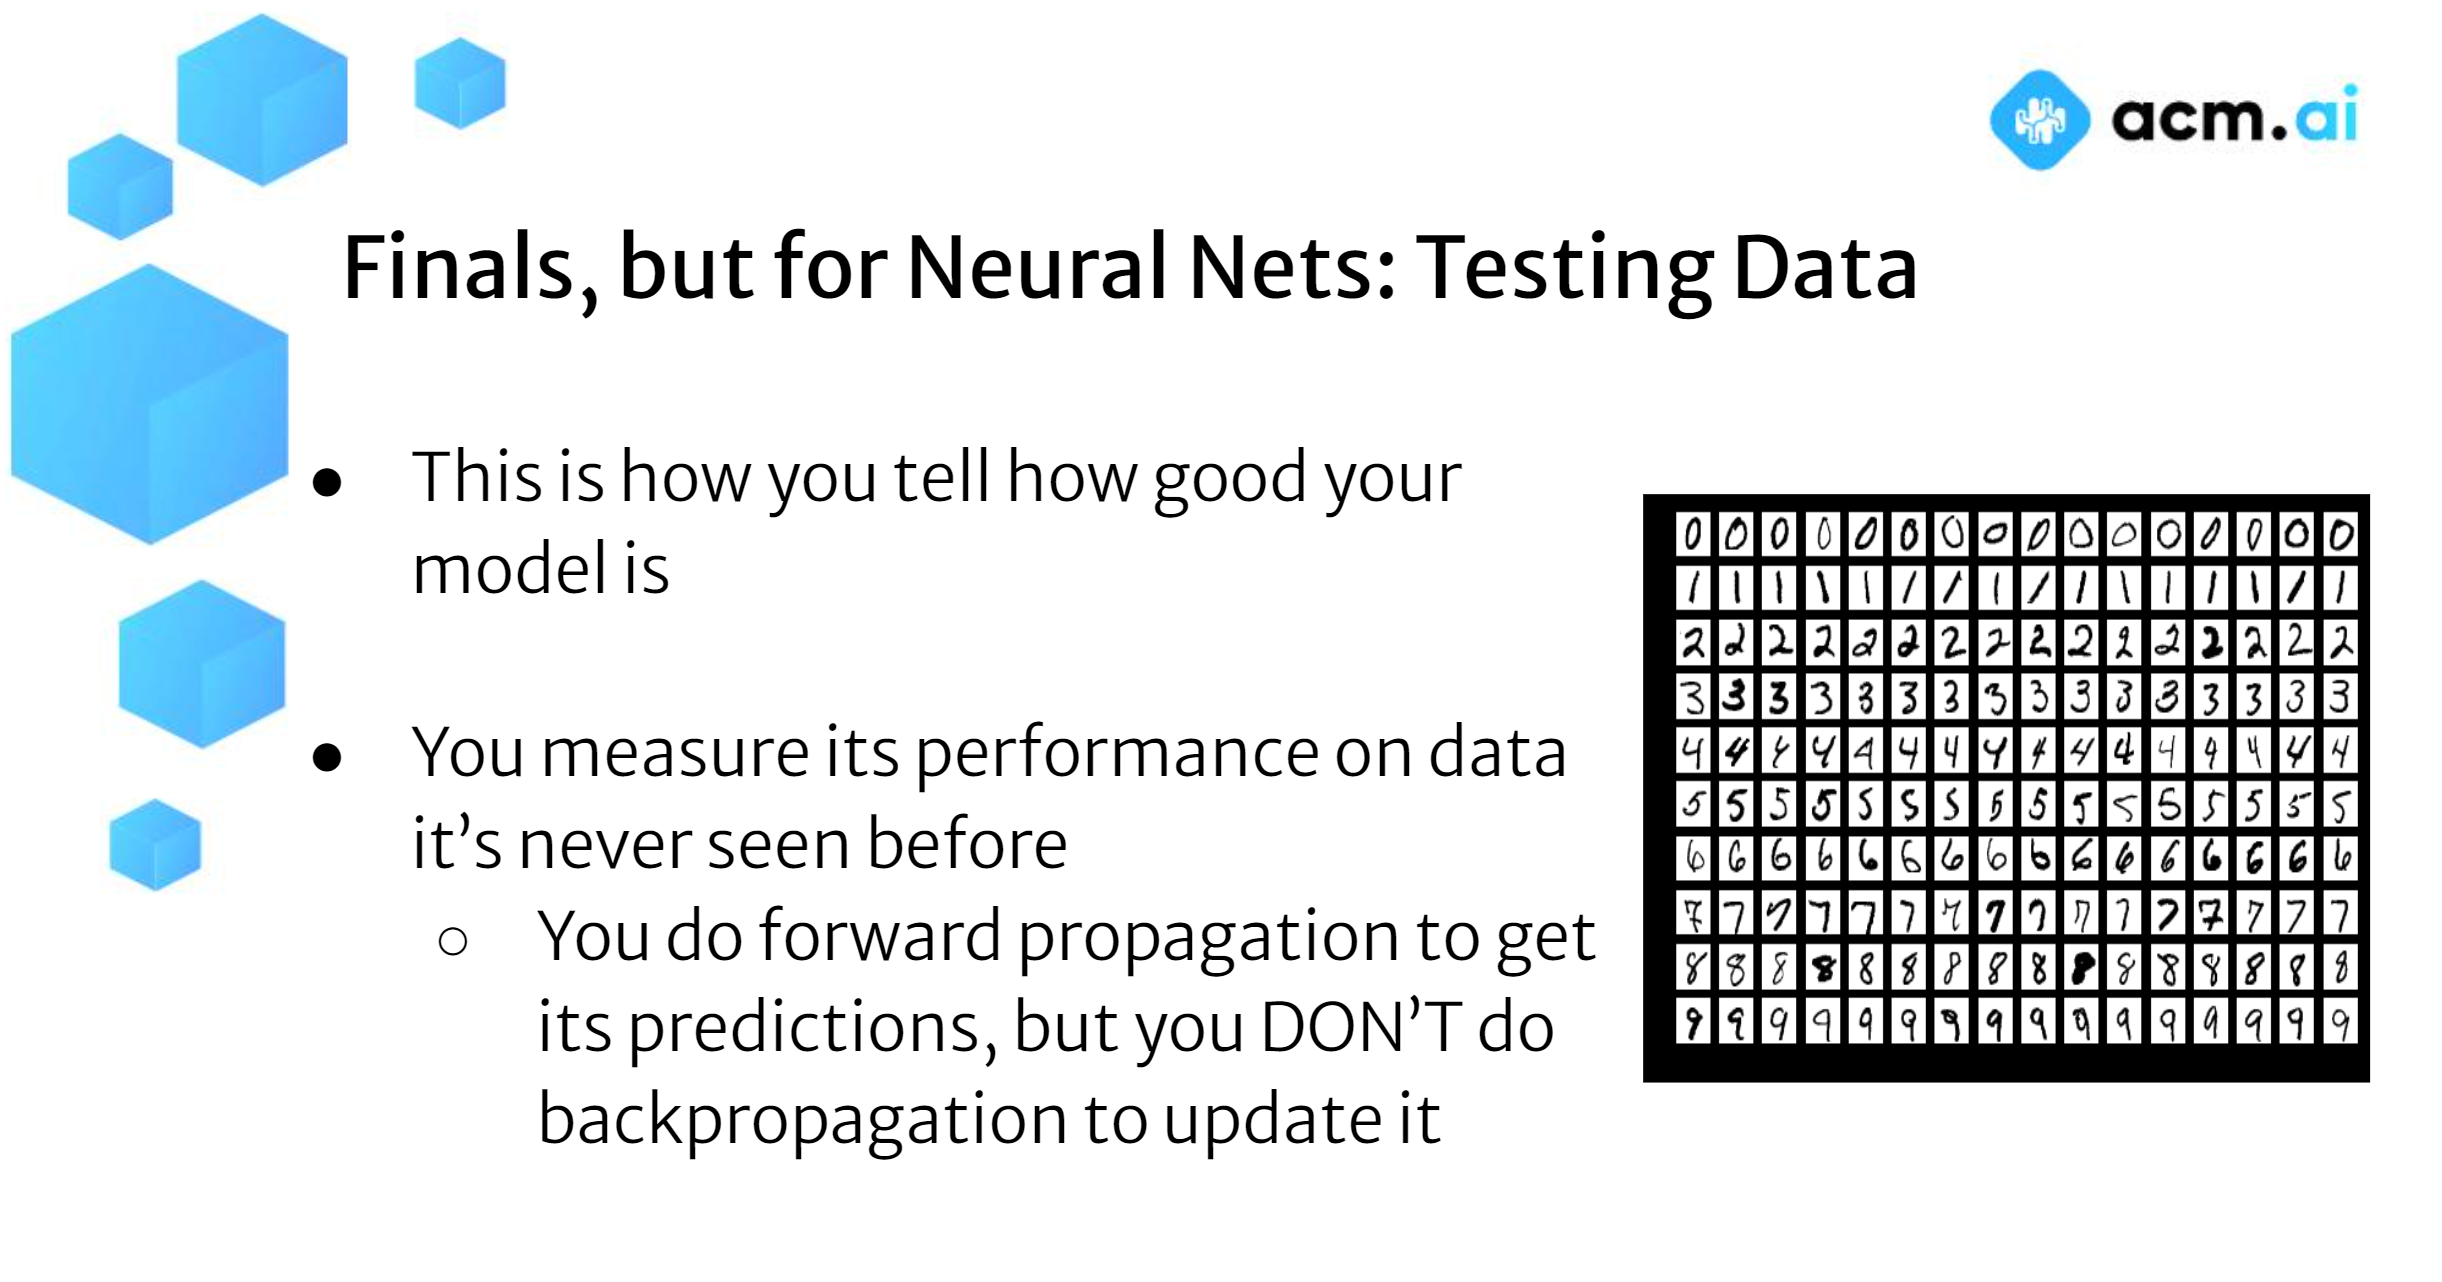

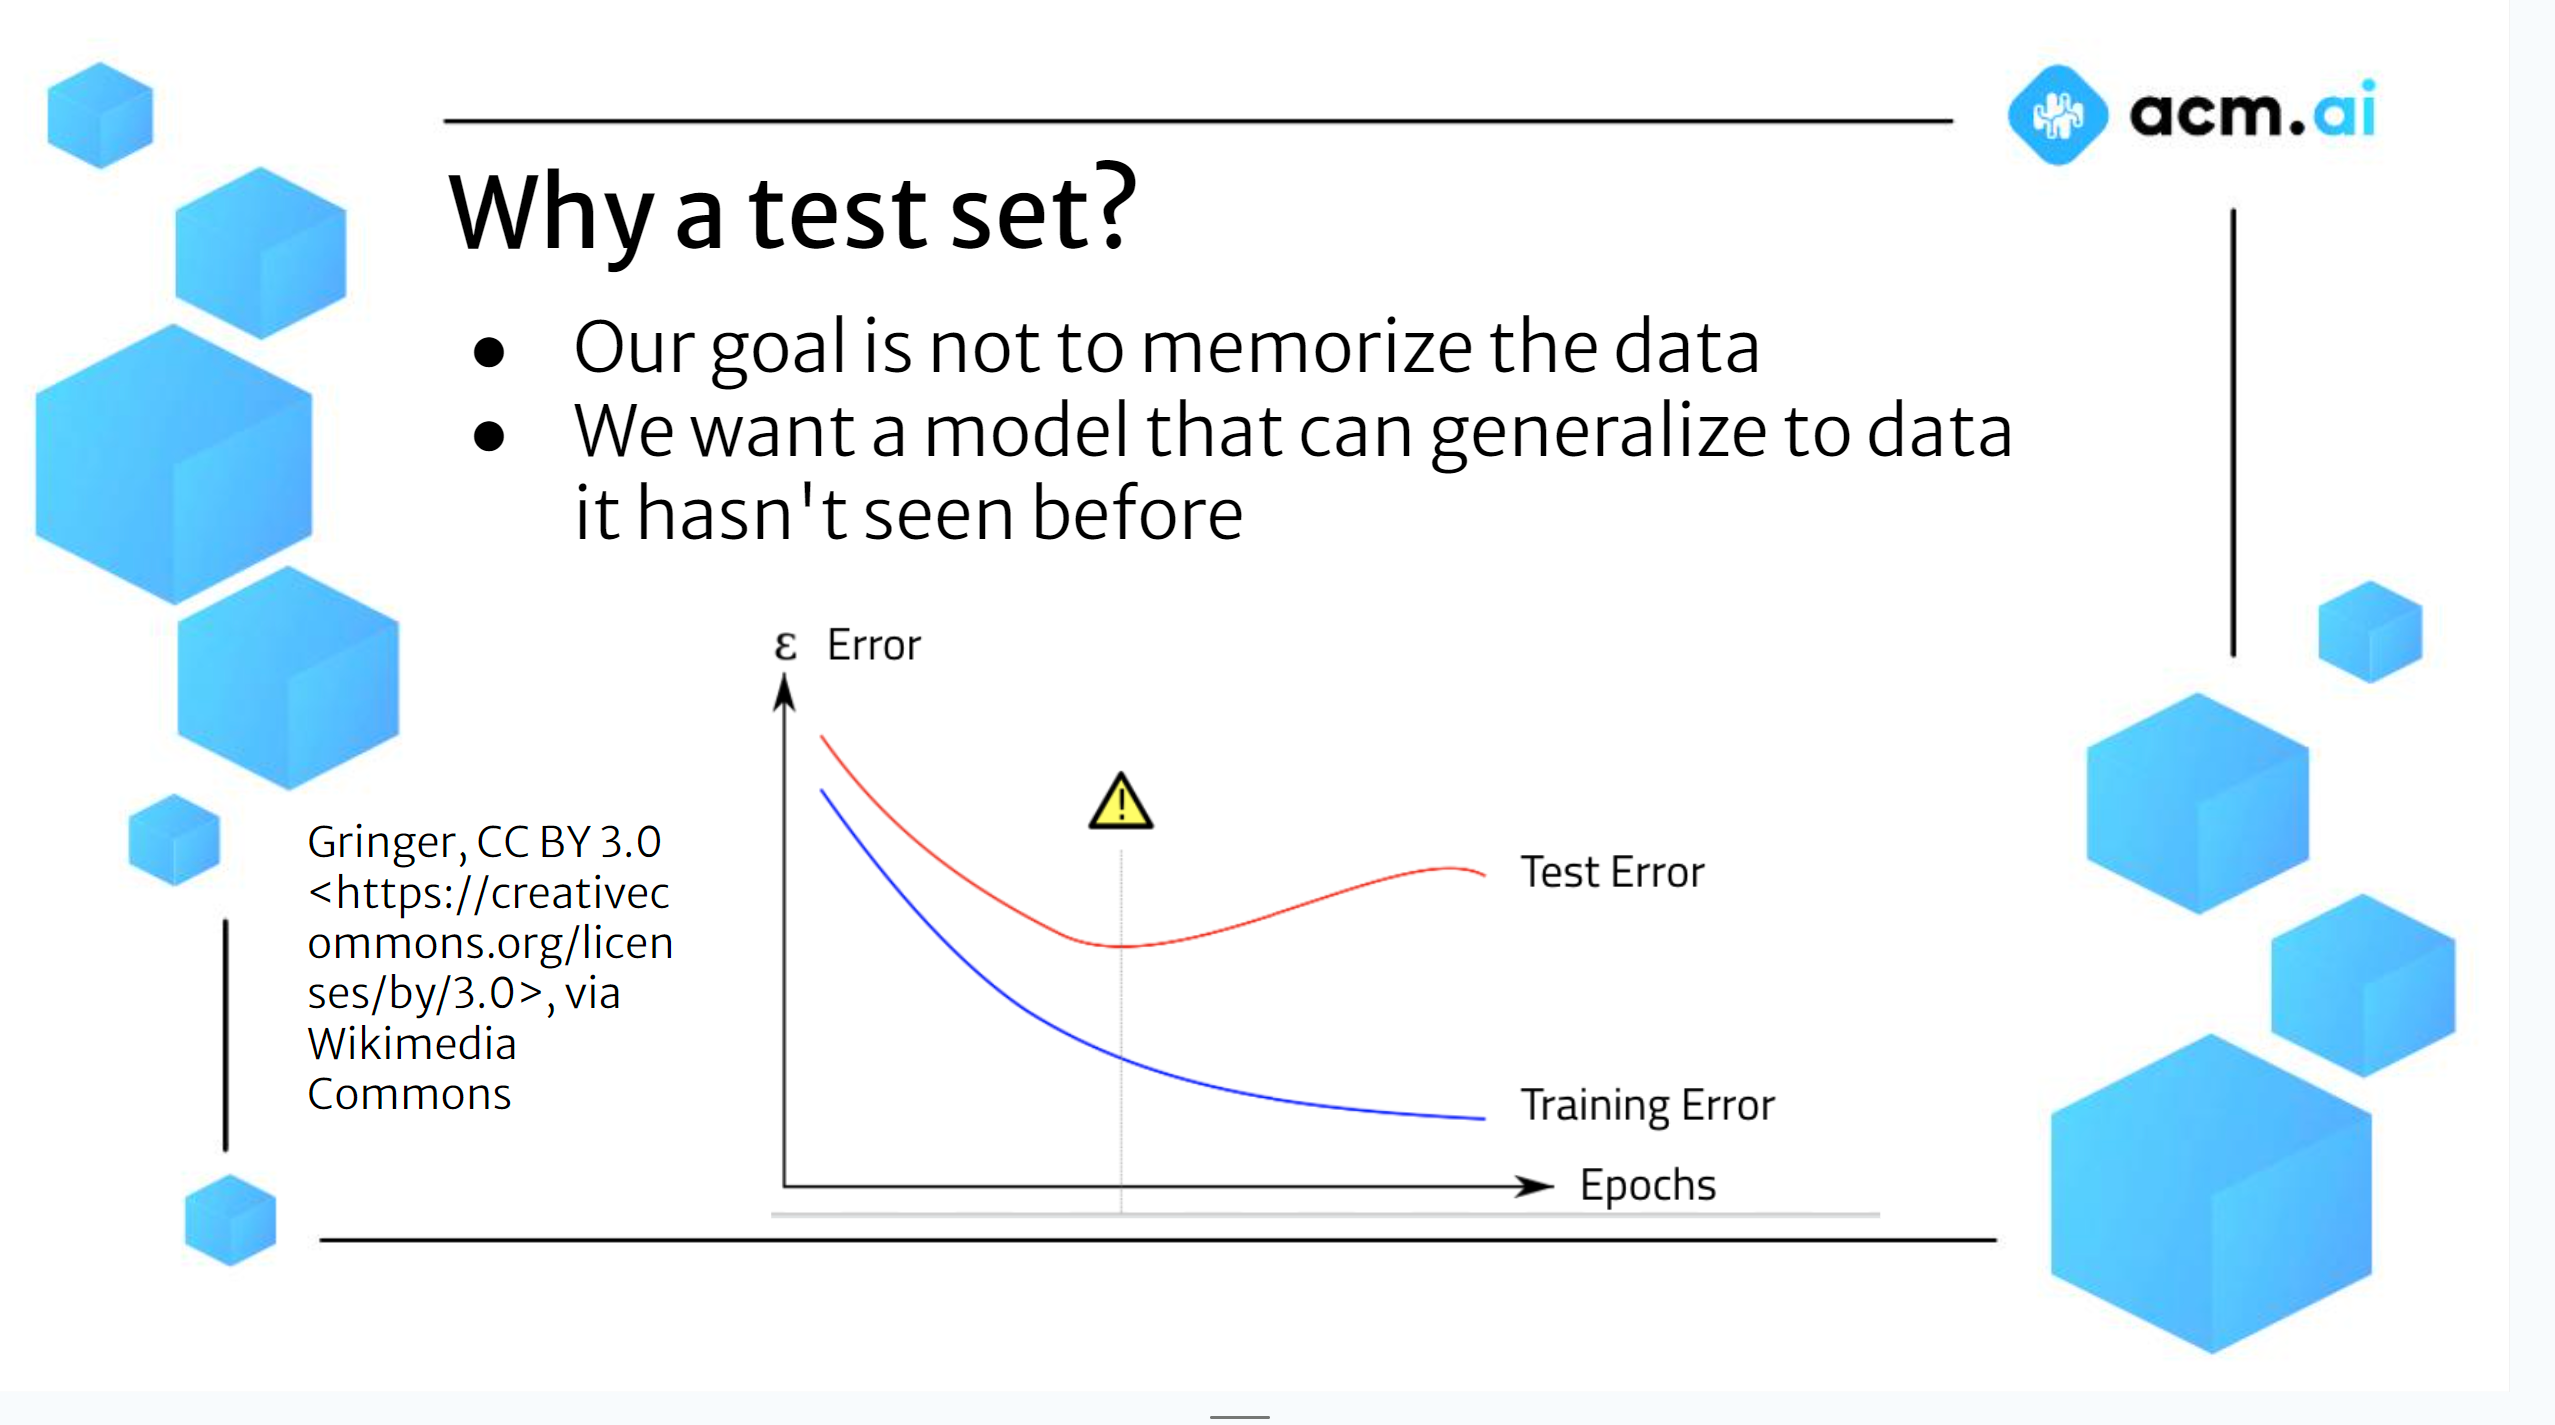

In [37]:
BATCH_SIZE = 16

trainData = datasets.MNIST("./data", train = True, transform = torchvision.transforms.ToTensor(), download = True)
testData = datasets.MNIST("./data", train = False, transform = torchvision.transforms.ToTensor(), download = True) #fill in the parameters for the testDataset using the trainData as a reference

trainDataLoader = torch.utils.data.DataLoader(trainData, batch_size = BATCH_SIZE, shuffle = True)
testDataLoader = torch.utils.data.DataLoader(testData, batch_size = BATCH_SIZE, shuffle = True)

model    = CustomModel()

# Seeing how the dataloader iterator works

In [38]:
testDataIterator = iter(testDataLoader)

True class: 5
Prediction: 5


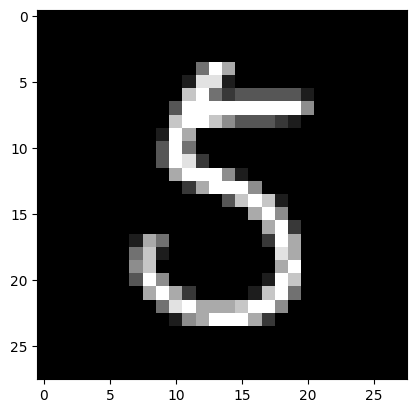

In [52]:
images, classes = iter(testDataLoader).__next__()
placeInBatch = random.randint(0, BATCH_SIZE-1)
image = images[placeInBatch]
trueClass = classes[placeInBatch]

print("True class:", trueClass.item())
print("Prediction:", model(torch.reshape(image, [1, 784])).argmax(axis = 1).item())
plt.imshow(image[0], cmap = "gray")
plt.show()

# Bringing it all together

If you implemented the code correctly, you should see the results of your model here

In [40]:
initialModelResults = evaluateModel(model, testDataLoader)


trainingLoop(model,
             trainDataLoader,
             nn.CrossEntropyLoss(),
             torch.optim.Adam(model.parameters(), lr = 0.01),
             2)


finalModelResults = evaluateModel(model, testDataLoader)

Epoch 1 over; loss at the end of the epoch: 0.9425559639930725
Epoch 2 over; loss at the end of the epoch: 0.6378406882286072


Before training the model...


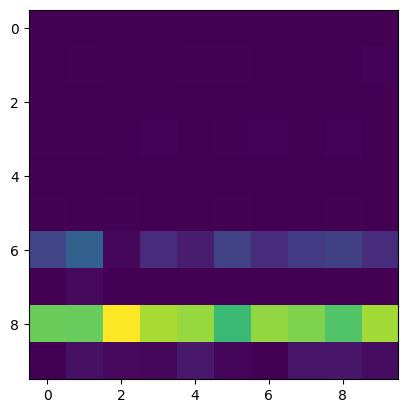

After training the model...


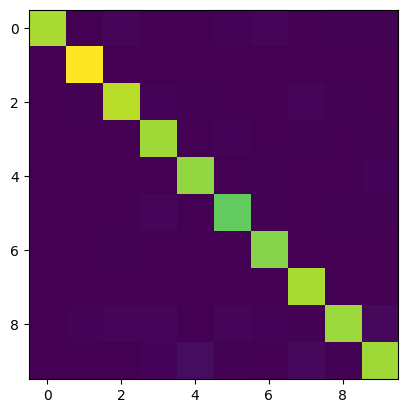

In [41]:
print("Before training the model...")
plt.imshow(metrics.confusion_matrix(initialModelResults[0], initialModelResults[1]))
plt.show()
print("After training the model...")
plt.imshow(metrics.confusion_matrix(finalModelResults[0], finalModelResults[1]))
plt.show()

# Let's see how the model does at predicting a specific sample

True class: 2
Prediction: 2


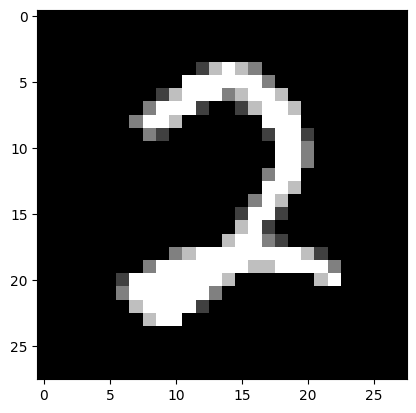

In [43]:
import random
placeInBatch = random.randint(0, BATCH_SIZE-1)
images, classes = iter(testDataLoader).__next__()

image = images[placeInBatch]
trueClass = classes[placeInBatch]

plt.imshow(image[0], cmap = "gray")
print("True class:", trueClass.item())
print("Prediction:", torch.argmax(model(image.view(1, 784))).item()) #reshape your image to the expected shape, plug it into the model, and extract the prediction (don't forget the .item() at the end)